In [28]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

from numpy.polynomial.polynomial import polyfit

import pyarrow as pa
import pyarrow.parquet as pq

import statsmodels.api as sm
import statsmodels
#import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelOLS

import warnings
warnings.filterwarnings("ignore")

### Preface

This notebook just explores the employment analysis part of the paper ["The Consumption Response to Trade Shocks: Evidence from the US-China Trade War."](http://www.waugheconomics.com/uploads/2/2/5/6/22563786/waugh_consumption.pdf) . This is in Section 5. It mimics many parts of the auto analysis (visualization, tabular representations, and regression analysis). Below I also report the unweighted an weighted regression results.

### Steup for analysis

Just some basic things, bring in the data, make the transformations that we want, etc...

In [29]:
fig_path = "C:\\github\\expenditure_tradeshocks\\figures"

This is the cell below to change if you want to toggle between all employment and only goods producing employment.

In [30]:
file_path = os.getcwd()

#trade_county = pq.read_table(file_path + "\\data\\trade_employment_goods.parquet").to_pandas()

trade_county = pq.read_table(file_path + "\\data\\trade_employment_all.parquet").to_pandas()

In [31]:
trade_county["time"] = pd.to_datetime(trade_county.time)

trade_county.set_index(["area_fips", "time"],inplace = True)

In [32]:
trade_county.head(30)

total_exp_pc  china_exp_pc    tariff  emplvl_2017  \
area_fips time                                                            
10001     2017-01-01    522.580597     58.368700  1.068759       2843.0   
          2017-02-01    502.309185     48.422056  1.068802       2843.0   
          2017-03-01    571.161328     42.286424  1.068895       2843.0   
          2017-04-01    509.278875     33.702476  1.068895       2843.0   
          2017-05-01    519.176693     33.878036  1.068895       2843.0   
          2017-06-01    509.383926     30.102481  1.068895       2843.0   
          2017-07-01    492.508803     32.581600  1.068895       2843.0   
          2017-08-01    509.577144     35.329198  1.068895       2843.0   
          2017-09-01    495.123610     44.380139  1.068895       2843.0   
          2017-10-01    569.787487     73.830992  1.068895       2843.0   
          2017-11-01    571.520102     73.114154  1.068895       2843.0   
          2017-12-01    553.649765     59.845960  1.068895       2843.0   
          2018-01-01    516.700915     48.624283  1.068805       2843.0   
          2018-02-01    516.145992     44.607737  1.068897       2843.0   
          2018-03-01    587.864923     42.979806  1.068894       2843.0   
          2018-04-01    559.410137     36.213274  1.393797       2843.0   
          2018-05-01    579.008640     33.254994  1.393798       2843.0   
          2018-06-01    558.919118     28.428818  1.393798       2843.0   
          2018-07-01    524.597360     25.288644  2.221774       2843.0   
          2018-08-01    545.616139     25.092559  2.221774       2843.0   
          2018-09-01    511.239593     21.133593  2.235515       2843.0   
          2018-10-01    562.324040     24.854552  2.485311       2843.0   
          2018-11-01    555.172968     25.784350  2.426361       2843.0   
          2018-12-01    524.630933     23.745690  2.426361       2843.0   
          2019-01-01    527.484006     29.783300  2.424109       2843.0   
          2019-02-01    505.126798     33.942512  2.424092       2843.0   
          2019-03-01    573.829215     35.695393  2.424058       2843.0   
          2019-04-01    541.332336     27.687231  2.424058       2843.0   
          2019-05-01    553.302909     33.524619  2.424057       2843.0   
          2019-06-01    526.449004     37.436249  2.424056       2843.0   

                       fips  total_employment  emply_month  
area_fips time                                              
10001     2017-01-01  10001           29514.0          0.0  
          2017-02-01  10001           29514.0          0.0  
          2017-03-01  10001           29514.0          0.0  
          2017-04-01  10001           29514.0          0.0  
          2017-05-01  10001           29514.0          0.0  
          2017-06-01  10001           29514.0          0.0  
          2017-07-01  10001           29514.0          0.0  
          2017-08-01  10001           29514.0          0.0  
          2017-09-01  10001           29514.0          0.0  
          2017-10-01  10001           29514.0          0.0  
          2017-11-01  10001           29514.0          0.0  
          2017-12-01  10001           29514.0          0.0  
          2018-01-01  10001           29514.0          0.0  
          2018-02-01  10001           29514.0          0.0  
          2018-03-01  10001           29514.0          0.0  
          2018-04-01  10001           29514.0          0.0  
          2018-05-01  10001           29514.0          0.0  
          2018-06-01  10001           29514.0          0.0  
          2018-07-01  10001           29514.0          0.0  
          2018-08-01  10001           29514.0          0.0  
          2018-09-01  10001           29514.0          0.0  
          2018-10-01  10001           29514.0          0.0  
          2018-11-01  10001           29514.0          0.0  
          2018-12-01  10001           29514.0          0.0  
          2019-01-01  10001        

In [33]:
trade_county["log_tariff"] = np.log(1+.01*trade_county["tariff"])

trade_county["log_exp_total"] = np.log(trade_county["total_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_exp_china"] = np.log(trade_county["china_exp_pc"]).replace(-np.inf, np.nan)

trade_county["log_employment"] = np.log(trade_county["emply_month"]).replace(-np.inf, np.nan)

trade_county["const"] = 1

In [34]:
trade_county.reset_index(inplace = True)

trade_county.rename({"area_fips": "GEOFIPS"},axis = 1, inplace = True)

trade_county["state_fips"] = trade_county["GEOFIPS"].astype(str).str[0:2]

trade_county["GEOFIPS"] = trade_county["GEOFIPS"].astype(int)

In [35]:
trade_county.set_index(["GEOFIPS", "time"], inplace = True)

In [36]:
trade_county.head()

total_exp_pc  china_exp_pc    tariff  emplvl_2017   fips  \
GEOFIPS time                                                                   
10001   2017-01-01    522.580597     58.368700  1.068759       2843.0  10001   
        2017-02-01    502.309185     48.422056  1.068802       2843.0  10001   
        2017-03-01    571.161328     42.286424  1.068895       2843.0  10001   
        2017-04-01    509.278875     33.702476  1.068895       2843.0  10001   
        2017-05-01    519.176693     33.878036  1.068895       2843.0  10001   

                    total_employment  emply_month  log_tariff  log_exp_total  \
GEOFIPS time                                                                   
10001   2017-01-01           29514.0          0.0    0.010631       6.258779   
        2017-02-01           29514.0          0.0    0.010631       6.219216   
        2017-03-01           29514.0          0.0    0.010632       6.347672   
        2017-04-01           29514.0          0.0    0.010632       6.232996   
        2017-05-01           29514.0          0.0    0.010632       6.252244   

                    log_exp_china  log_employment  const state_fips  
GEOFIPS time                                                         
10001   2017-01-01       4.066780             NaN      1         10  
        2017-02-01       3.879955             NaN      1         10  
        2017-03-01       3.744466             NaN      1         10  
        2017-04-01       3.517571             NaN      1         10  
        2017-05-01       3.522767             NaN      1         10

### Simple Cuts of Employment Data by Tariff Exposure

Here is the strategy. First, compute the quantiles of tariff exposure for each county. Then compute year over year sales growth for each county. Note that since this is in growth rates, this takes out any county level "fixed effect" and removes any seasonal component. 

Then we will simply plot year over year employment growth, for the (mean or median) county in a particular part of the distribution of tariff exposure.

This stuff is not reported in the paper, but is here to mimic the results for the autos.

Note the stuff below will also replicate the summary statistics in the paper.

In [37]:
# First take growth rates

# note , I'm a bit confused about why the sorting,
# here is that because of some missing values, the resulting dateframe from the 
# first operation may be out of place, so we need to resort things to make sure that
# the time difference is correct.

trade_county["tariff_change"] = trade_county.groupby(["GEOFIPS"]).tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["log_tariff_change"] = trade_county.groupby(["GEOFIPS"]).log_tariff.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

trade_county["employment_growth"] = trade_county.groupby(["GEOFIPS"]).log_employment.diff(12)

trade_county.sort_values(["GEOFIPS", "time"], inplace = True)

In [38]:
# Then what we will do is look at the change in the taiff distribution...

exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).tariff_change, 4 ,labels = False)

#median_exposure = pd.qcut(trade_county.xs('2018-12-1', level=1).alt_tariff, 5 ,labels = False)

In [39]:
most_exposed = exposure[exposure == 3].index.tolist()

mid_group = exposure.isin([1,2])

med_exposed = exposure[mid_group].index.tolist()

least_exposed = exposure[exposure == 0].index.tolist()

trade_county.xs('2018-12-1', level=1).tariff_change.mean()


1.5170590547540457

In [40]:
print("Tariff Change-Most:", round(trade_county.loc[most_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Midl:", round(trade_county.loc[med_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Lest:",round(trade_county.loc[least_exposed].xs('2018-12-1', level=1).tariff_change.mean(),2))
print("Tariff Change-Mean:", round(trade_county.xs('2018-12-1', level=1).tariff_change.mean(),2))

Tariff Change-Most: 3.81
Tariff Change-Midl: 1.05
Tariff Change-Lest: 0.15
Tariff Change-Mean: 1.52


In [41]:
print("Chinese Exports 2017, (Most, Middle, Least, Mean)")

measure = "china_exp_pc"

print(round(trade_county.loc[most_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({measure :"mean"}).loc["2017"].sum()[0],0))

print(round(trade_county.groupby("time").agg({measure:"mean"}).loc["2017"].sum()[0],0))

Chinese Exports 2017, (Most, Middle, Least, Mean)
4041.0
1303.0
347.0
1879.0


In [42]:
print("Annual Employment, (Most, Middle, Least, Mean)")

print(round(trade_county.loc[most_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[med_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.loc[least_exposed].groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

print(round(trade_county.groupby("time").agg({"emply_month":"mean"}).loc["2017"].mean()[0],0))

Annual Employment, (Most, Middle, Least, Mean)
11585.0
54571.0
32474.0
38144.0


Now we will plot a comparision between those who are most exposed and those whoe are the least exposed (in terms of changes). This is basically the difference in difference by visualization.

In [43]:
empl_most = trade_county.loc[most_exposed].groupby("time").agg({"employment_growth":"mean"})

empl_least = trade_county.loc[least_exposed].groupby("time").agg({"employment_growth":"mean"})

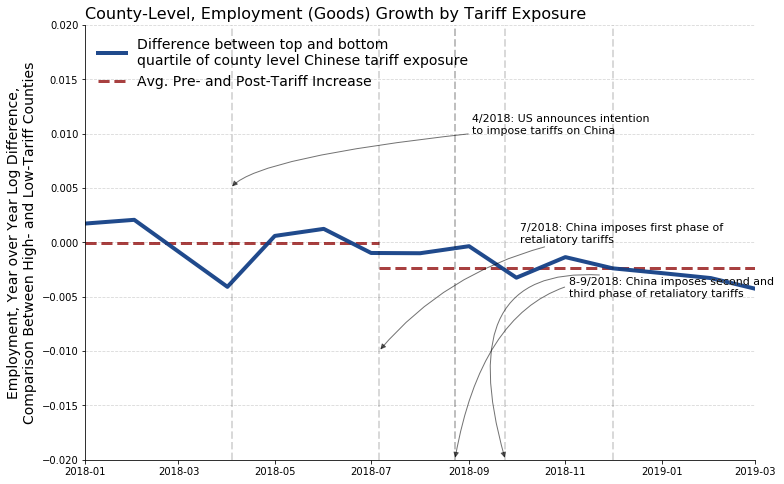

In [44]:
fig, ax = plt.subplots(figsize = (12,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot((empl_most - empl_least), alpha = 0.95, color = mike_blue, linewidth = 4, 
        label = 'Difference between top and bottom\nquartile of county level Chinese tariff exposure')

#ax.plot(, alpha = 0.95, color = mike_blue , linewidth = 4, 
#        label = 'Bottom Quantile of Chinese Tariff Exposure Counties')

ax.set_ylim(-0.02,0.02)

ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.set_ylabel("Employment, Year over Year Log Difference,\nComparison Between High- and Low-Tariff Counties", fontsize = 14)

ax.hlines((empl_most - empl_least).loc[:"2018-07-01"].mean().iloc[0],
          dt.datetime(2018,1,1),dt.datetime(2018,7,6),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--")

ax.hlines((empl_most - empl_least).loc["2018-08-01":].mean().iloc[0],
          dt.datetime(2018,7,6),dt.datetime(2019,3,1),
           linewidth = 3, color = 'darkred', alpha =0.75, linestyle = "--", label = "Avg. Pre- and Post-Tariff Increase")

ax.axvline(dt.datetime(2018,4,4), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,7,6), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,8,23), linewidth = 2, ls = "--", color = 'k', alpha =0.25)

ax.axvline(dt.datetime(2018,9,24), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.axvline(dt.datetime(2018,12,1), linewidth = 2, ls = "--", color = 'k', alpha =0.15)

ax.legend(loc = 0, frameon  = False, fontsize = 14)

ax.set_title("County-Level, Employment (Goods) Growth by Tariff Exposure", fontsize = 16, loc= "left" )

##############################################################################################

ax.annotate(
    "4/2018: US announces intention\nto impose tariffs on China", 
    xy=(dt.datetime(2018,4,3), 0.005), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,9,3), 0.01), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

ax.annotate(
    "7/2018: China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -0.01), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,10,3), 0.0), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,8,23), -0.02), color='white',# This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "8-9/2018: China imposes second and \nthird phase of retaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -0.02), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,11,3), -0.005), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=286",
        "color": "black",
        "alpha": 0.55
    },
    fontsize=11,
)

##############################################################################################

#plt.savefig(fig_path + "\\simple_employment_county_all.pdf", bbox_inches = "tight", dip = 3600)

plt.show()

Then this will do the tabular representation using stuff before and after the first phase of the tradewar.

In [45]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-01-01":"2018-06-01"],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

0.0099 0.001 4689
0.0098 0.001 4614


In [46]:
idx = pd.IndexSlice

me_mean = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

me_nobs = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

me_se = trade_county.loc[most_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5


le_mean = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.mean()

le_nobs = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.notnull().sum()

le_se = trade_county.loc[least_exposed].loc[idx[:,"2018-07-01":],:].employment_growth.std()/me_nobs**0.5

print(round(me_mean,4), round(me_se,3), me_nobs)
print(round(le_mean,4), round(le_se,3), le_nobs)

0.0092 0.001 7047
0.0114 0.001 6939


Not discussed in the paper, but what this looks like is that both looked relativly the same before the start of it interms of employment growth. But after the first phase, the least exposed did really well (this is consistent with a rocking US economy) but those most exposed did relativly poorly. But growth here is still positive. 

### Regression Analysis

This will walk through the results using employment data. The first set are the main (weighted results). The next set are the unweighted results. Numbers may not exactly match up to what is in the paper as some rounding is occuring. 

In [47]:
trade_county.columns

Index(['total_exp_pc', 'china_exp_pc', 'tariff', 'emplvl_2017', 'fips',
       'total_employment', 'emply_month', 'log_tariff', 'log_exp_total',
       'log_exp_china', 'log_employment', 'const', 'state_fips',
       'tariff_change', 'log_tariff_change', 'employment_growth'],
      dtype='object')

### Weighted Results

#### Change on Change, no time or fixed effects

In [48]:
all_vars = ["const", "log_tariff_change", 'employment_growth','total_employment']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset['total_employment'].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0045
Estimator:                   PanelOLS   R-squared (Between):              0.0046
No. Observations:               47061   R-squared (Within):               0.0043
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0045
Time:                        07:23:00   Log-likelihood                 1.155e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.113e+04
Entities:                        3145   P-value                           0.0000
Avg Obs:                       14.964   Distribution:                 F(1,47059)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             99.931
                            

#### Change on Change, now with just the time effect.

In [49]:
all_vars = ["const", "log_tariff_change", 'employment_growth','total_employment']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset['total_employment'].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0050
Estimator:                   PanelOLS   R-squared (Between):              0.0050
No. Observations:               47061   R-squared (Within):               0.0019
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0042
Time:                        07:23:01   Log-likelihood                 1.156e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.124e+04
Entities:                        3145   P-value                           0.0000
Avg Obs:                       14.964   Distribution:                 F(1,47045)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             112.44
                            

#### Change on Change, time effects and county-level fixed effects

In [50]:
all_vars = ["const", "log_tariff_change", 'employment_growth','total_employment']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

weights = dataset['total_employment'].to_frame()
# I fought with this alot. the weights shape needs to exaclty match up
# with the dataframe for which the estimation is done. So what I do is
# slice as above, then let PanelOLS drop things when there are missing 
# observations

weights.replace(to_replace = 0, value = 0.001,inplace = True)
# Some countys because of there size and how the QCEW deals with stuff, there are is zero.
# PanelOLS does not like 0 weight, so this the the work around. It does not matter. 

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], weights = weights, entity_effects=True, 
               time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0053
Estimator:                   PanelOLS   R-squared (Between):              0.0047
No. Observations:               47061   R-squared (Within):               0.0040
Date:                Fri, Oct 04 2019   R-squared (Overall):              0.0045
Time:                        07:23:02   Log-likelihood                 1.461e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   8.511e+04
Entities:                        3145   P-value                           0.0000
Avg Obs:                       14.964   Distribution:                 F(1,43901)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             63.606
                            

### Unweigted resuts

#### Change on Change, no fixed effects or time effects

In [51]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars])

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

#df = pd.concat([dataset.employment_growth, fe_res.fitted_values],1).dropna()
#print(df.corr().iloc[0,1] ** 2)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                     8.389e-05
Estimator:                   PanelOLS   R-squared (Between):           9.062e-05
No. Observations:               47061   R-squared (Within):            4.898e-05
Date:                Fri, Oct 04 2019   R-squared (Overall):           8.389e-05
Time:                        07:23:02   Log-likelihood                  6.91e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.9483
Entities:                        3145   P-value                           0.0469
Avg Obs:                       14.964   Distribution:                 F(1,47059)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             1.5161
                            

#### Change on Change, time effects

In [52]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):           9.351e-05
No. Observations:               47061   R-squared (Within):            1.892e-05
Date:                Fri, Oct 04 2019   R-squared (Overall):            7.69e-05
Time:                        07:23:03   Log-likelihood                 6.912e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.2505
Entities:                        3145   P-value                           0.0219
Avg Obs:                       14.964   Distribution:                 F(1,47045)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             1.8511
                            

#### Change on Change, time and county-level fixed effects

In [53]:
all_vars = ["const", "log_tariff_change", 'employment_growth']

dataset = trade_county[all_vars].loc[idx[:,"2018-01-01":"2019-03-01"],:]

exog_vars = ["const","log_tariff_change"]

mod = PanelOLS(dataset.employment_growth, dataset[exog_vars], entity_effects=True, time_effects = True)

fe_res = mod.fit(cov_type='clustered')

print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:      employment_growth   R-squared:                     9.484e-05
Estimator:                   PanelOLS   R-squared (Between):           9.315e-05
No. Observations:               47061   R-squared (Within):            3.842e-05
Date:                Fri, Oct 04 2019   R-squared (Overall):           8.259e-05
Time:                        07:23:03   Log-likelihood                  9.19e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.1641
Entities:                        3145   P-value                           0.0413
Avg Obs:                       14.964   Distribution:                 F(1,43901)
Min Obs:                       3.0000                                           
Max Obs:                       15.000   F-statistic (robust):             1.2444
                            

This is the most interesting one. Here things go to zero and there is no effect. What I think the weighting is really doing is variance reduction rather than some issue about means. So there are a bunch of small county's with employment patterns all over the place. By weighting on county size, this reduces the impact those guys have and, hence, you get the different result. 

In [54]:
1*(3.92-0.15)

3.77